In [1]:
import argparse
from collections import defaultdict
import multiprocessing as mp
import os
import pickle
import re
import subprocess
import sys

from joblib import Parallel, delayed
import numpy as np
# import ray
# # use fewer CPUs so the OS doesn't run out of processes
# ray.init(num_cpus=16)
# import modin.pandas as pd
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

log = sys.stdout

## Functions:

In [2]:
def all_unique(iterable):
    """
    Input: an iterable
    Output: whether or not it doesn't contain duplicates
    """
    filtered = np.unique(iterable)
    return len(iterable) == len(filtered)


def parse_header(path_to_vcf):
    """ 
    Input: path to vcf
    Output: list of the column names
    """
    try:
        n_lines_to_skip = int(subprocess.check_output(
            "grep -Ec '^#{{2}}' {}".format(path_to_vcf), 
            shell=True
        ).decode("utf-8"))
    except subprocess.CalledProcessError as err: 
        if err.returncode == 1:
            n_lines_to_skip = 0
        else: 
            raise err
    header_line = subprocess.check_output(
        "sed -n '{}p' {}".format(n_lines_to_skip + 1, path_to_vcf), 
        shell=True
    ).decode("utf-8").strip("#\n")
    print(header_line)
    column_names = header_line.split('\t')
    return column_names, n_lines_to_skip


def read_vcf(path_to_vcf, usecols=None, **pd_kwargs):
    """
    Skip metadata and read only the specified columns from th
    """
    column_names, n_lines_to_skip = parse_header(path_to_vcf)
    if usecols is not None:
        usecols[0] = "#" + usecols[0]
    resulting_df = pd.read_csv(
        path_to_vcf, sep='\t', 
        skiprows=n_lines_to_skip, 
        usecols=usecols,
        **pd_kwargs
    )
    resulting_df.rename(columns={
        resulting_df.columns[0] 
        : resulting_df.columns[0].strip('#')
       }, inplace=True
    )
    return resulting_df


def dump_pkl(obj, path):
    with open(path, "wb") as outfile:
        pickle.dump(obj, outfile)
        
        
def load_pkl(path):
    with open(path, "rb") as infile:
        return pickle.load(infile)

## Reading data

In [3]:
# raw_vcf = "full_na_raw.vcf"
raw_vcf = "phased_raw.tsv"
# phasing_vcf = "/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/whatshap_phasing/outs/phased_wgs.vcf"
phasing_vcf = "phasing.vcf"
ref_genome = "/icgc/dkfzlsdf/analysis/B260/users/n790i/tools/binning_the_genome/humangenes_biomart_GRCh37p13.sort.bed"
prefix = "scRNA"

In [4]:
!mkdir "tmp_ase"

mkdir: cannot create directory ‘tmp_ase’: File exists


In [4]:
genome_df = pd.read_csv(
    ref_genome, 
    sep='\t', 
    header=0, 
    names=parse_header(ref_genome)[0]
) 

chr	start	end	GeneName	GeneID


In [5]:
phasing_df = pd.read_csv(
    phasing_vcf,
    sep='\t'
)

In [8]:
# phasing_df.rename(columns={
#         "sample_blood_XI046_ST_LFS_1" 
#         : "INFO"
#     }, inplace=True
# )
# is_phased = np.fromiter(
#     (("0|1" in s) or ("1|0" in s) 
#     for s in phasing_df.INFO),
#     dtype=bool
# )
# assert is_phased.size == phasing_df.shape[0], "phasing_vcf contains non-phased entries"
# phasing_df = phasing_df[is_phased]
raw_df = pd.read_csv(prefix + "/scRNA.csv").to_sparse()
# raw_df = pd.read_pickle("phased_raw.pkl")

chr	start	end	GeneName	GeneID


<string>:2: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270

CPU times: user 24min 28s, sys: 3min 35s, total: 28min 3s
Wall time: 28min 18s


In [19]:
%%time
barcode_list = []
barcode_pattern = r"^(A|G|C|T)+-1"
for colname in tqdm_notebook(raw_df.columns, desc="cell barcode"):
    if re.match(barcode_pattern, colname) is not None:
        barcode_list.append(colname)
        # dirty hack to handle NaN: NaN != NaN. 
        # For some reason, it hangs if I try selecting entries that aren't NaN
        raw_df[colname] = raw_df[colname].apply(lambda s: ':'.join(s.split(":")[2:4]) if s==s else s) 


CPU times: user 8.42 s, sys: 523 ms, total: 8.94 s
Wall time: 8.29 s


In [15]:
raw_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 343349 entries, 0 to 343348
Columns: 6673 entries, CHROM to TTTGTCATCCCAAGAT-1
dtypes: Sparse[int64, nan](2), Sparse[object, nan](6671)
memory usage: 25.5 MB


In [16]:
print("genome_df, {}:\n{}".format(genome_df.shape, genome_df.head()), file=log)
print("raw_df, {}:\n{}".format(raw_df.shape, raw_df.head()), file=log)
print("phasing_df, {}:\n{}".format(phasing_df.shape, phasing_df.head()), file=log)
print("loaded everything into RAM", file=log)

genome_df, (57773, 5):
  chr  start    end    GeneName           GeneID
0   1  11869  14412     DDX11L1  ENSG00000223972
1   1  14363  29806      WASH7P  ENSG00000227232
2   1  29554  31109  MIR1302-10  ENSG00000243485
3   1  34554  36081     FAM138A  ENSG00000237613
4   1  52473  54936      OR4G4P  ENSG00000268020
raw_df, (343349, 6673):
   CHROM    POS REF ALT AAACCTGCACATCCAA-1 AAACCTGCACTAGTAC-1  \
0      1  14907   A   G                NaN                NaN   
1      1  14976   G   A                NaN                NaN   
2      1  15118   A   G                NaN                NaN   
3      1  15211   T   G                NaN                NaN   
4      1  16068   T   C                NaN                NaN   

  AAACCTGCATCATCCC-1 AAACCTGGTAGCGATG-1 AAACCTGGTAGCTCCG-1 AAACCTGGTCCGAATT-1  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN     

In [17]:
raw_df.to_pickle("scRNA/cleaned_scDNA.pkl")

In [10]:
# raw_df.drop(columns=["ID", "QUAL", "FILTER", "FORMAT"], inplace=True)

In [11]:
# raw_df.to_csv("full_na_raw.vcf", sep='\t', index=False, na_rep="NA")

## Extracting SNPs

In [6]:
raw_df = pd.read_pickle("scRNA/cleaned_scDNA.pkl")

In [33]:
%%time
raw_snps = [
    "{}_{}".format(chrom, pos) 
    for chrom, pos in 
    raw_df[["CHROM", "POS"]].values
]
phasing_snps = [
    "{}_{}".format(chrom, pos) 
    for chrom, pos in 
    phasing_df[["CHROM", "POS"]].values
]
assert all_unique(raw_snps) and all_unique(phasing_snps), "duplicate SNPs detected (wtf?)"
common_snps = set(raw_snps) & set(phasing_snps)
print("{} SNPs in the sample, {} SNPs in the phasing data, {} common SNPs ({:.2f}%)".format(
    raw_df.shape[0], phasing_df.shape[0], 
    len(common_snps), 100 * len(common_snps) / raw_df.shape[0]
))
print("raw_snps: ", raw_snps[:10], file=log)
print("phasing_snps: ", phasing_snps[:10], file=log)
print("common_snps: ", list(common_snps)[:10], file=log)

240959 SNPs in the sample, 1556362 SNPs in the phasing data, 194637 common SNPs (80.78%)
raw_snps:  ['1_14907', '1_14976', '1_15118', '1_15211', '1_16068', '1_16103', '1_16298', '1_16378', '1_16495', '1_16534']
phasing_snps:  ['1_14464', '1_14907', '1_14976', '1_15118', '1_15211', '1_15447', '1_16068', '1_16103', '1_16298', '1_16378']
common_snps:  ['12_11258149', '14_35921835', '17_43337136', '1_205199440', '2_207023620', '6_109880451', '1_53046230', '15_28115853', '5_137069187', '11_98978554']
CPU times: user 8.62 s, sys: 266 ms, total: 8.88 s
Wall time: 8.88 s


In [34]:
raw_snp_to_idx = { snp : i for i, snp in enumerate(raw_snps) }
common_snps_ids = sorted([raw_snp_to_idx[snp] for snp in common_snps])

In [28]:
with open(prefix + "/common_snps_ids.txt", "w") as outfile:
    outstr = '\n'.join([str(idx+1)+'p' for idx in common_snps_ids])
    outfile.write(outstr)

## Dropping out SNPs with unknown phasing

In [30]:
phasing_df["snp"] = phasing_snps

In [31]:
phasing_df = phasing_df[phasing_df.snp.isin(common_snps)]

In [32]:
phasing_df.shape

(240960, 6)

In [33]:
phasing_df.sort_values(by="snp", inplace=True)
print("filtered the dataframes", file=log)

filtered the dataframes


## Extraсting phasing information

In [34]:
phasing_df["phase"] = phasing_df.INFO.apply(lambda s: s.split(":")[0] == '1|0')
phasing_df.drop("INFO", axis=1, inplace=True)
print("extracted the phase labels", file=log)

AttributeError: 'DataFrame' object has no attribute 'INFO'

In [36]:
raw_df = pd.read_csv("scRNA/filtered_scRNA.csv").to_sparse()

/home/v390v/.conda/envs/vivanov/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,

## Integrating phasing information into main DataFrame

In [37]:
raw_df["PHASE"] = phasing_df["PHASE"]
del phasing_df # now we don't need it any longer
print("dropped the phasing_df", file=log)

dropped the phasing_df


In [39]:
raw_df.to_pickle(prefix + "/phased_raw.pkl")

In [40]:
raw_df.head()

,CHROM,POS,REF,ALT,AAACCTGCACATCCAA-1,AAACCTGCACTAGTAC-1,AAACCTGCATCATCCC-1,AAACCTGGTAGCGATG-1,AAACCTGGTAGCTCCG-1,AAACCTGGTCCGAATT-1,...,TTTGTCACACTGTGTA-1,TTTGTCACAGTCAGCC-1,TTTGTCAGTACAAGTA-1,TTTGTCAGTAGAGTGC-1,TTTGTCAGTGCGCTTG-1,TTTGTCAGTGTTTGTG-1,TTTGTCAGTTAAAGAC-1,TTTGTCATCATCGGAT-1,TTTGTCATCCCAAGAT-1,PHASE
0,1,14907,A,G,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,14976,G,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1,15118,A,G,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1,15211,T,G,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,16068,T,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Mapping SNPs to genes (and the other way around)

In [7]:
raw_df = pd.read_pickle(prefix+"/phased_raw.pkl")

In [18]:
raw_df["AAACCTGGTCCGAATT-1"].value_counts()

0/0:-0.00,-0.69,-8.47:0:1:0:0,1,0,0,0          7
1/1:-9.39,-0.69,-0.00:1:1:0:1,0,0,0,0          7
0/0:-0.00,-0.69,-9.39:0:1:0:0,0,1,0,0          7
0/0:-0.00,-0.69,-9.39:0:1:0:0,1,0,0,0          6
0/0:-0.00,-0.69,-9.39:0:1:0:0,0,0,1,0          4
1/1:-9.39,-0.69,-0.00:1:1:0:0,0,0,1,0          4
0/0:-0.04,-0.72,-4.32:0:1:0:0,1,0,0,0          3
1/1:-9.39,-0.69,-0.00:1:1:0:0,1,0,0,0          3
0/0:-0.00,-0.69,-8.47:0:1:0:0,0,0,1,0          3
0/0:-0.00,-1.39,-18.78:0:2:0:0,2,0,0,0         2
0/0:-0.04,-0.72,-4.32:0:1:0:0,0,0,1,0          2
1/1:-9.39,-0.69,-0.00:1:1:0:0,0,1,0,0          2
1/1:-4.32,-0.72,-0.04:1:1:0:0,0,1,0,0          2
1/1:-5.93,-0.70,-0.01:1:1:0:1,0,0,0,0          2
0/0:-0.04,-0.72,-4.32:0:1:0:0,0,1,0,0          2
0/0:-0.00,-0.69,-9.39:0:1:0:1,0,0,0,0          2
0/0:-0.00,-4.16,-55.41:0:6:0:0,0,6,0,0         1
0/0:-0.00,-2.08,-28.16:0:3:0:0,0,3,0,0         1
1/1:-16.93,-1.39,-0.00:2:2:0:2,0,0,0,0         1
1/1:-74.36,-6.29,-0.08:9:9:0:0,0,0,9,0         1
1/1:-43.26,-3.47,-0.

In [41]:
genome_df.head()

,chr,start,end,GeneName,GeneID
0,1,11869,14412,DDX11L1,ENSG00000223972
1,1,14363,29806,WASH7P,ENSG00000227232
2,1,29554,31109,MIR1302-10,ENSG00000243485
3,1,34554,36081,FAM138A,ENSG00000237613
4,1,52473,54936,OR4G4P,ENSG00000268020


In [9]:
snp_df = raw_df[["CHROM", "POS"]]

In [10]:
raw_df.ALT.value_counts()

T    62505
A    62467
C    58233
G    57754
Name: ALT, dtype: int64

In [11]:
chrom_to_genes = {}

for chrom in genome_df["chr"].value_counts().keys():
    chrom_to_genes[chrom] = genome_df[genome_df.chr == chrom]

In [12]:
%%time

def pool_handler(snp_tuple):
    chrom, pos = snp_tuple
    pos -= 1 # 1-based to 0-based
    genes = chrom_to_genes[str(chrom)]
    mask = (genes.start <= pos) & (pos < genes.end)
    return ';'.join(genes[mask].GeneID)

# pool = mp.Pool(16)
result = [pool_handler(snp_tuple) 
          for snp_tuple in tqdm_notebook(snp_df.values)]
# pool.close()
# pool.join()


CPU times: user 8min 26s, sys: 46.9 s, total: 9min 13s
Wall time: 8min 24s


In [13]:
snp_to_genes, gene_to_snps = {}, defaultdict(list)
for i, row in enumerate(snp_df.values):
    chrom, pos = row
    snp = f"{chrom}_{pos}"
    snp_to_genes[snp] = result[i].split(";") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)
    
with open(prefix+"/snp_to_genes.pkl", "wb") as outfile:
    pickle.dump(snp_to_genes, outfile)
    
with open(prefix+"/gene_to_snps.pkl", "wb") as outfile:
    pickle.dump(gene_to_snps, outfile)

In [ ]:
for c in raw_df.columns:
    print(c, raw_df[c].isna().sum() / raw_df.shape[0] * 100)

CHROM 0.0
POS 0.0
REF 0.0
ALT 0.0
AAACCTGCACGACTAT-1 92.79749673020365
AAACCTGTCTTGCGAA-1 94.27355782822411
AAACGGGAGTGTTGAA-1 98.0235682928604
AAACGGGGTACTCACA-1 94.13787174412967
AAAGCAAAGCTGGTCC-1 95.34011355901313
AAAGCAAAGGCCATAG-1 95.79398898411887
AACACGTCACTGCGCA-1 96.73806017198066
AACACGTTCGATAGTC-1 96.63811484568042
AACCATGGTAAGTGTA-1 93.24654232317502
AACTCCCAGAGTAATC-1 94.5939366931363
AACTCCCAGGGATTCG-1 95.72025354686772
AACTCTTGTCCGATGC-1 95.82792660458294
AACTCTTTCAAGTTGC-1 94.0978807340572
AAGACCTCACAAACTC-1 95.38403283255488
AAGCCGCCAGACACGA-1 94.91734225285265
AAGGCAGCAAGCAAGC-1 93.5615761738585
AAGGCAGTCAGATTCG-1 95.95659333264213
AAGTCTGAGCACAGGT-1 92.84244636793404
AAGTCTGTCTACCGTC-1 93.64973670975093
AATCGGTTCGCGATGC-1 94.40067901000033
ACACCCTCATACGTTG-1 96.26918006837755
ACACCGGAGGCATATA-1 96.09962076158081
ACACTGACAGGATCCC-1 98.49702063755072
ACACTGAGTGCGGTAA-1 95.46671955869502
ACAGCTACATAGTGTC-1 94.73979762359379
ACATACGCACTGGCCA-1 97.71368626312024
ACATACGT

## Loading barcoded columns and extracting read counts

In [20]:
%%time
# extract barcoded columns
# parse those and split each such column into two different ones: DP and AD
counts_df = pd.SparseDataFrame()
phase = raw_df.PHASE.values.to_dense()
male_alt = phase == 1

for barcode in tqdm_notebook(barcode_list, desc="cell_barcode"):
    column = raw_df[barcode].to_dense()
    ad = column.apply(
        lambda s: int(s.split(":")[0]) if s==s else s
    ).astype(np.float32)
    dp = column.apply(
        lambda s: int(s.split(":")[1]) if s==s else s
    ).astype(np.float32)    
    ad[male_alt] = dp[male_alt] - ad[male_alt]
    counts_df[f"{barcode}_ad"] = ad.to_sparse()
    counts_df[f"{barcode}_dp"] = dp.to_sparse()


CPU times: user 1h 26min 5s, sys: 12.6 s, total: 1h 26min 18s
Wall time: 1h 26min 8s


In [26]:
counts_df.head()

,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,AAACCTGGTAGCTCCG-1_dp,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
counts_df["AAACCTGCACATCCAA-1_ad"].value_counts()

0.0     24
1.0     18
3.0      2
7.0      2
5.0      1
8.0      1
18.0     1
11.0     1
Name: AAACCTGCACATCCAA-1_ad, dtype: int64

In [22]:
counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240959 entries, 0 to 240958
Columns: 13338 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: Sparse[float32, nan](13338)
memory usage: 15.0 MB


In [23]:
counts_df.to_pickle(prefix+"/counts_df.pkl")

## Aggregating read counts over genes

In [41]:
gene_to_snps = load_pkl(prefix+"/gene_to_snps.pkl")
snp_to_genes = load_pkl(prefix+"/snp_to_genes.pkl")
snp_counts_df = pd.read_pickle(prefix+"/counts_df.pkl")
gene_counts_df = pd.SparseDataFrame()
snp_list = list(raw_snps)

In [42]:
snp_counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 240959 entries, 0 to 240958
Columns: 13338 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: Sparse[float32, nan](13338)
memory usage: 15.0 MB


In [43]:
snp_to_idx = {snp : i for i, snp in tqdm_notebook(enumerate(snp_list))}

In [44]:
snp_counts_df.head()

,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,AAACCTGGTAGCTCCG-1_dp,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
gene_to_snp_ids = {gene : [snp_to_idx[snp] for snp in snp_list] 
                   for gene, snp_list in tqdm_notebook(gene_to_snps.items(), desc="mapping refinement")}

def process_barcode(barcode):
    gene_to_ad, gene_to_dp = [], []
    ad = snp_counts_df[f"{barcode}_ad"].values.to_dense()
    dp = snp_counts_df[f"{barcode}_dp"].values.to_dense()
    for gene in gene_to_snps.keys():
        snp_ids = gene_to_snp_ids[gene]
        gene_to_ad.append(np.nansum(ad[snp_ids]))
        gene_to_dp.append(np.nansum(dp[snp_ids]))
    return pd.SparseDataFrame({f"{barcode}_ad" : gene_to_ad, 
                               f"{barcode}_dp" : gene_to_dp})

pool = mp.Pool(8)
result_list = pool.map(process_barcode, 
                       tqdm_notebook(barcode_list, 
                                     desc="cell_barcode processing"))
pool.close()
pool.join()

# for barcode in tqdm_notebook(barcode_list, desc="cell_barcode processing"):
#     result_list.append(process_barcode(barcode))
#     gene_to_ad, gene_to_dp = [], []
#     ad = snp_counts_df[f"{barcode}_ad"].values.to_dense()
#     dp = snp_counts_df[f"{barcode}_dp"].values.to_dense()
#     for gene in gene_to_snps.keys():
#         snp_ids = gene_to_snp_ids[gene]
#         gene_to_ad.append(np.nansum(ad[snp_ids]))
#         gene_to_dp.append(np.nansum(dp[snp_ids]))
#     gene_counts_df[f"{barcode}_ad"] = gene_to_ad
#     gene_counts_df[f"{barcode}_dp"] = gene_to_dp

In [55]:
gene_counts_df = pd.concat(result_list, axis=1).to_dense()

In [56]:
gene_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15760 entries, 0 to 15759
Columns: 13338 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: float64(13338)
memory usage: 1.6 GB


In [58]:
gene_counts_df.shape

(15760, 13338)

In [60]:
gene_counts_df.insert(column="GENE", loc=0, value=list(gene_to_snps.keys()))
gene_counts_df.shape

(15760, 13339)

In [61]:
gene_counts_df.head()

,GENE,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000239906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000228463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ENSG00000230021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
gene_ordering = {gene : i for i, gene in enumerate(genome_df.GeneID)}
gene_counts_df["GENE_IDX"] = [gene_ordering[gene] for gene in gene_counts_df.GENE]
gene_counts_df.sort_values(by="GENE_IDX", inplace=True)
gene_counts_df.drop(columns=["GENE_IDX"], inplace=True)
gene_counts_df.reset_index(drop=True, inplace=True)
gene_counts_df.head()

,GENE,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000239906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000228463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ENSG00000230021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
for colname in gene_counts_df.columns:
    if re.match(barcode_pattern, colname) is None:
        print(colname)

GENE


In [64]:
gene_counts_df.to_pickle(prefix+"/gene_counts.pkl")

## Getting an ASE matrix

In [70]:
gene_counts_df = pd.read_pickle(prefix+"/gene_counts.pkl")

ase_df = pd.concat([
    pd.DataFrame({
        f"{barcode}" 
        : gene_counts_df[f"{barcode}_ad"] 
        / gene_counts_df[f"{barcode}_dp"]
    }) 
    for barcode in barcode_list], 
    axis=1
)
ase_df.insert(0, "GENE", gene_counts_df["GENE"])
ase_df.head()

,GENE,AAACCTGCACATCCAA-1,AAACCTGCACTAGTAC-1,AAACCTGCATCATCCC-1,AAACCTGGTAGCGATG-1,AAACCTGGTAGCTCCG-1,AAACCTGGTCCGAATT-1,AAACCTGGTCTAAACC-1,AAACCTGGTGGTGTAG-1,AAACCTGGTTTGTTGG-1,...,TTTGTCAAGCGTTCCG-1,TTTGTCACACTGTGTA-1,TTTGTCACAGTCAGCC-1,TTTGTCAGTACAAGTA-1,TTTGTCAGTAGAGTGC-1,TTTGTCAGTGCGCTTG-1,TTTGTCAGTGTTTGTG-1,TTTGTCAGTTAAAGAC-1,TTTGTCATCATCGGAT-1,TTTGTCATCCCAAGAT-1
0,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000228463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000230021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sns.set()
plt.figure(figsize=(20,10))
plt.title("number of non-missing entries in the ASE matrix computed from scRNA data (one point per cell)", fontsize=20)
sns.distplot([(~ase_df[barcode].isna()).sum()
              for barcode in barcode_list])

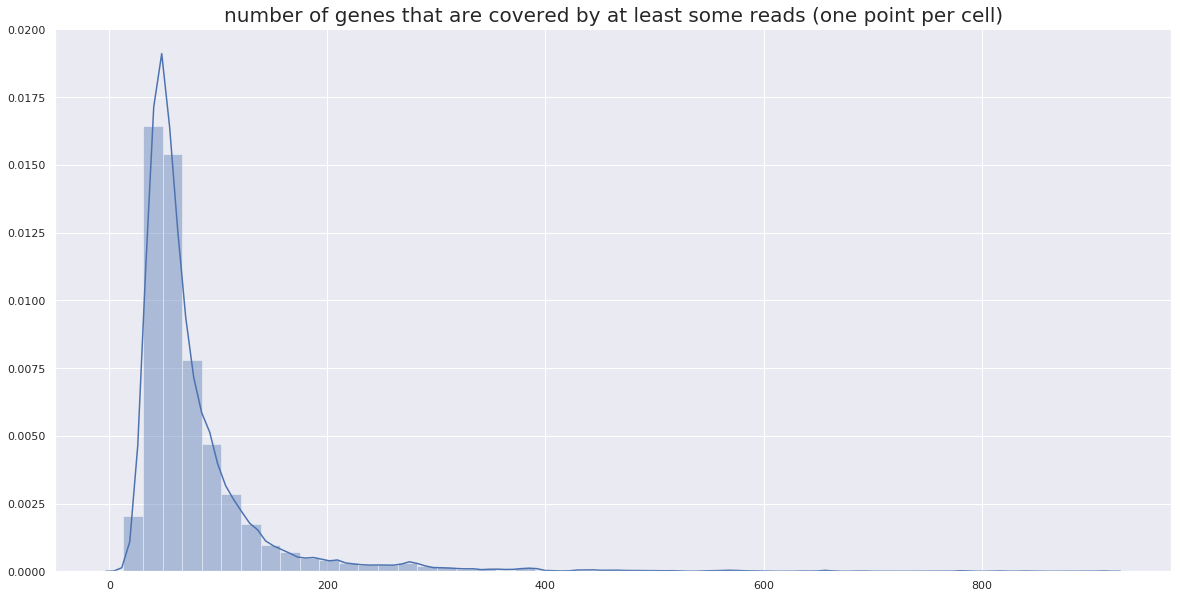

In [90]:
sns.set()
plt.figure(figsize=(20,10))
plt.title("number of genes that are covered by at least some reads (one point per cell)", fontsize=20)
sns.distplot([
    (gene_counts_df[f"{barcode}_dp"].dropna().values > 0).sum() 
    for barcode in barcode_list
])

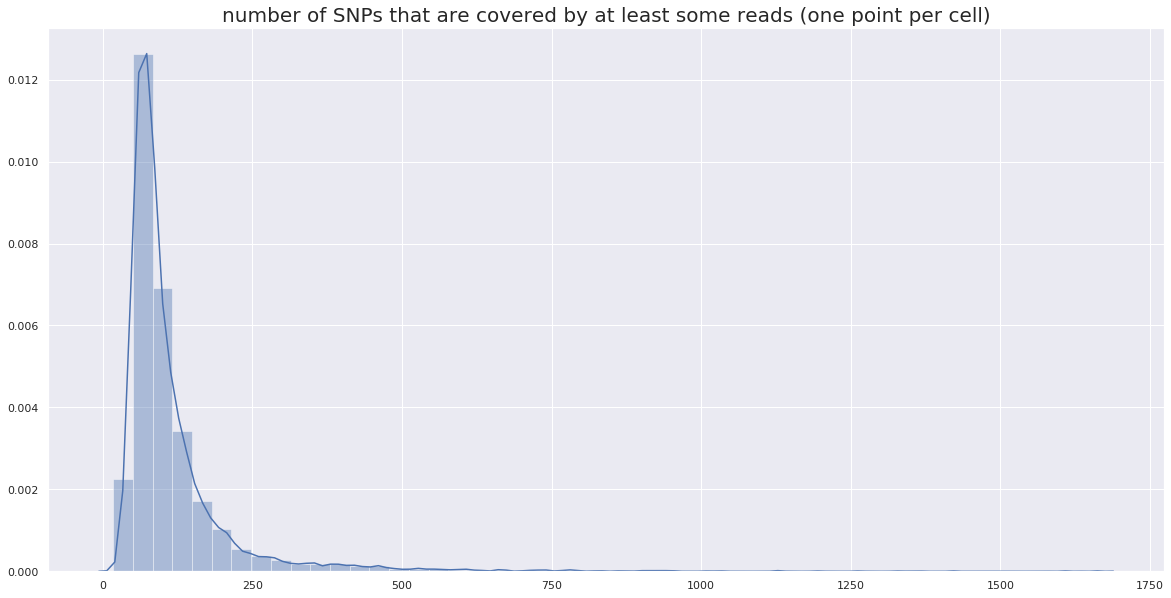

In [86]:
sns.set()
plt.figure(figsize=(20,10))
plt.title("number of SNPs that are covered by at least some reads (one point per cell)", fontsize=20)

sns.distplot([
    (counts_df[f"{barcode}_dp"].dropna().values > 0).sum() 
    for barcode in tqdm_notebook(barcode_list)
]);

In [95]:
ase_df.to_pickle("scRNA/ase_df.pkl")

## Assigning labels via ASE profiles

In [176]:
scDNA_ase_df = pd.read_pickle("ase_df.pkl").to_dense()
scRNA_counts_df = pd.read_pickle("scRNA/gene_counts.pkl").to_dense()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Data columns (total 4 columns):
GENE    23037 non-null Sparse[object, nan]
1       22998 non-null Sparse[float64, nan]
2       20419 non-null Sparse[float64, nan]
3       22588 non-null Sparse[float64, nan]
dtypes: Sparse[float64, nan](3), Sparse[object, nan](1)
memory usage: 720.0 KB


In [143]:
gene_ordering = {gene : i for i, gene in enumerate(genome_df.GeneID)}
scDNA_ase_df["GENE_IDX"] = [gene_ordering[gene] 
                            for gene in scDNA_ase_df.GENE]
scDNA_ase_df.sort_values(by="GENE_IDX", inplace=True)
scDNA_ase_df.drop(columns=["GENE_IDX"], inplace=True)

scDNA_ase_df.reset_index(drop=True, inplace=True)
scDNA_ase_df.head()

,GENE,1,2,3
0,ENSG00000227232,0.691275,0.333333,0.833333
1,ENSG00000268020,0.750000,0.400000,0.714286
2,ENSG00000240361,0.387755,0.571429,0.454545
3,ENSG00000238009,0.510823,0.542857,0.439716
4,ENSG00000239945,0.521739,0.750000,0.272727


In [131]:
%%time
barcode_list = []
barcode_pattern = r"^(A|G|C|T)+-1_[ad|dp]"
for colname in tqdm_notebook(scRNA_counts_df.columns, 
                             desc="cell barcode"):
    if re.match(barcode_pattern, colname) is not None:
        barcode_list.append(colname.split("_")[0])
barcode_list = np.unique(barcode_list)

CPU times: user 190 ms, sys: 16.1 ms, total: 207 ms
Wall time: 194 ms


In [169]:
scDNA_ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Data columns (total 4 columns):
GENE    23037 non-null Sparse[object, nan]
1       22998 non-null Sparse[float64, nan]
2       20419 non-null Sparse[float64, nan]
3       22588 non-null Sparse[float64, nan]
dtypes: Sparse[float64, nan](3), Sparse[object, nan](1)
memory usage: 720.0 KB


In [181]:
scDNA_genes = scDNA_ase_df.GENE
scRNA_genes = scRNA_counts_df.GENE
common_genes = set(scDNA_genes) & set(scRNA_genes)
scDNA_ase_df = scDNA_ase_df[scDNA_ase_df.GENE.isin(common_genes)]
scRNA_counts_df = scRNA_counts_df[scRNA_counts_df.GENE.isin(common_genes)]

In [183]:
scDNA_ase_df.shape

(14497, 4)

In [184]:
scRNA_counts_df.shape

(14497, 13339)

In [188]:
labels = []

def assign_label(barcode):
    loglikelihood = []
    for cluster_label in scDNA_ase_df.columns[1:]:
        Nm = scRNA_counts_df[f"{barcode}_ad"]
        Np = scRNA_counts_df[f"{barcode}_dp"] - Nm
        profile = scDNA_ase_df[cluster_label].values.to_dense()
        loglikelihood.append(
            (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().sum()
            + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().sum()
        )
    return np.nanargmax(loglikelihood)

pool = mp.Pool(8)
labels = pool.map(assign_label,tqdm_notebook(barcode_list, desc="barcode processing"))
pool.close()
pool.join()

# for barcode in tqdm_notebook(barcode_list, desc="barcode processing"):
#     loglikelihood = []
#     for cluster_label in scDNA_ase_df.columns[1:]:
#         Nm = scRNA_counts_df[f"{barcode}_ad"]
#         Np = scRNA_counts_df[f"{barcode}_dp"] - Nm
#         profile = scDNA_ase_df[cluster_label].values.to_dense()
#         loglikelihood.append(
#             (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().sum()
#             + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().sum()
#         )
#     labels.append(np.nanargmax(loglikelihood))

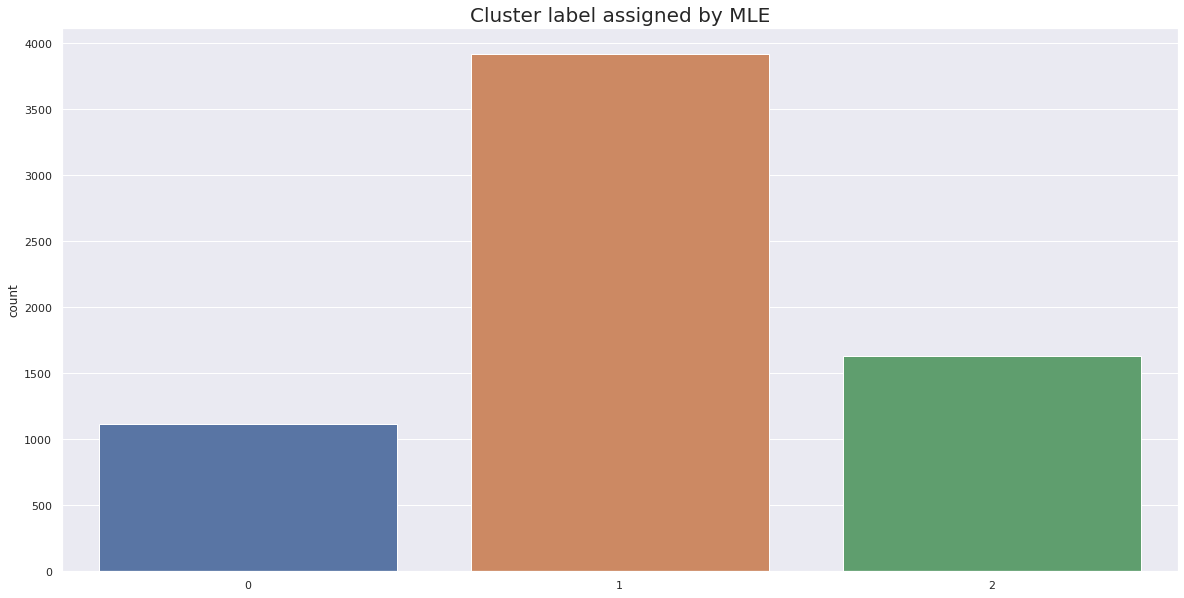

In [191]:
sns.set()
plt.figure(figsize=(20,10))
plt.title("Cluster label assigned by MLE", fontsize=20)
sns.countplot(labels)

In [196]:
barcode_list

array(['AAACCTGCACATCCAA-1', 'AAACCTGCACTAGTAC-1', 'AAACCTGCATCATCCC-1',
       ..., 'TTTGTCAGTTAAAGAC-1', 'TTTGTCATCATCGGAT-1',
       'TTTGTCATCCCAAGAT-1'], dtype='<U18')

In [198]:
labels_df = pd.DataFrame(np.column_stack((barcode_list, labels)), 
                         columns=["barcode", "cluster"])
labels_df.to_csv("scRNA/labels.tsv", sep='\t')

## Aggregating by cell barcode

In [172]:
gene_counts_df = pd.read_pickle("gene_counts.pkl")
cell_gene_counts = pd.DataFrame()
cell_gene_counts["GENE"] = gene_counts_df["GENE"]

In [173]:
clustering_tsv = "/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/single_cell_integration_dna_rna/scrna_vs_scdna/outs/Sample1_scDNA_clustering_info.tsv"

In [174]:
clustering_df = pd.read_csv(clustering_tsv, sep='\t', usecols=["cl_hierarchical", "barcode"])
clustering_df.head()

,cl_hierarchical,barcode
0,1,AAACCTGTCTTGCGAA-1
1,2,AACTCCCAGGGATTCG-1
2,1,CACCTTGAGAAGGACA-1
3,3,CACCTTGAGGTAAACT-1
4,3,CAGAGAGGTTCCCACT-1


In [175]:
barcode_to_cluster = {
    barcode : cluster_id
    for cluster_id, barcode in
    clustering_df.values
}

In [176]:
n_clusters = clustering_df.cl_hierarchical.value_counts().size
n_clusters

3

In [177]:
n_genes = gene_counts_df.shape[0]
for i in range(1, n_clusters + 1):
    cell_gene_counts[f"cluster_{i}_ad"] = np.zeros(n_genes)
    cell_gene_counts[f"cluster_{i}_dp"] = np.zeros(n_genes)
cell_gene_counts.head()

,GENE,cluster_1_ad,cluster_1_dp,cluster_2_ad,cluster_2_dp,cluster_3_ad,cluster_3_dp
0,ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000268020,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000240361,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0
4,ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
cluster_label_list = clustering_df.cl_hierarchical.unique()
cluster_label_list 

array([1, 2, 3])

In [179]:
for cluster_label in tqdm_notebook(cluster_label_list, desc="cluster"): 
    barcode_group = clustering_df.query(f"cl_hierarchical == {cluster_label}").barcode
    for barcode in tqdm_notebook(barcode_group, desc="barcodes in cluster"):
        prefix = f"cluster_{cluster_label}"
        cell_gene_counts[prefix + "_dp"] += gene_counts_df[f"{barcode}_dp"]
        cell_gene_counts[prefix + "_ad"] += gene_counts_df[f"{barcode}_ad"]
        

In [180]:
cell_gene_counts.head()

,GENE,cluster_1_ad,cluster_1_dp,cluster_2_ad,cluster_2_dp,cluster_3_ad,cluster_3_dp
0,ENSG00000227232,103.0,149.0,3.0,9.0,45.0,54.0
1,ENSG00000268020,27.0,36.0,2.0,5.0,10.0,14.0
2,ENSG00000240361,19.0,49.0,4.0,7.0,5.0,11.0
3,ENSG00000238009,236.0,462.0,19.0,35.0,62.0,141.0
4,ENSG00000239945,12.0,23.0,3.0,4.0,3.0,11.0


In [181]:
cell_gene_counts.to_pickle("cell_gene_counts.pkl")

In [182]:
ase_df = pd.DataFrame(columns=[i+1 for i in range(n_clusters)])
ase_df.insert(0, "GENE", cell_gene_counts["GENE"])
for i in range(n_clusters):
       ase_df[i+1] = (cell_gene_counts[f"cluster_{i+1}_ad"] 
                    / cell_gene_counts[f"cluster_{i+1}_dp"])
ase_df.head()

,GENE,1,2,3
0,ENSG00000227232,0.691275,0.333333,0.833333
1,ENSG00000268020,0.750000,0.400000,0.714286
2,ENSG00000240361,0.387755,0.571429,0.454545
3,ENSG00000238009,0.510823,0.542857,0.439716
4,ENSG00000239945,0.521739,0.750000,0.272727


In [183]:
ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Data columns (total 4 columns):
GENE    23037 non-null Sparse[object, nan]
1       22998 non-null Sparse[float64, nan]
2       20419 non-null Sparse[float64, nan]
3       22588 non-null Sparse[float64, nan]
dtypes: Sparse[float64, nan](3), Sparse[object, nan](1)
memory usage: 720.0 KB


<Figure size 1440x2160 with 0 Axes>

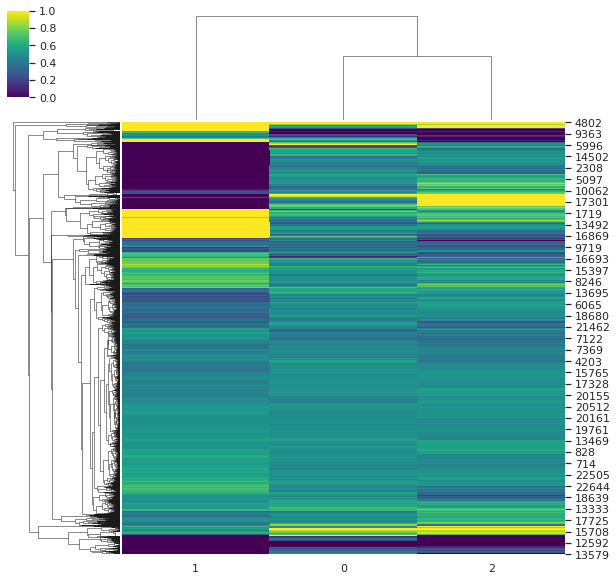

In [184]:
plt.figure(figsize=(20,30))
sns.clustermap(
    ase_df\
    .drop(columns=["GENE"])\
    .fillna(value=0)\
    .astype(np.float32)\
    .values,
    cmap="viridis"
);

In [185]:
ase_df.to_pickle("ase_df.pkl")